In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [18]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [19]:
root = '../Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

class_names = train_data.classes

In [20]:
class_names

['CAT', 'DOG']

In [21]:
len(train_data)

18743

In [22]:
len(test_data)

6251

In [23]:
for images, labels in train_loader:
    break

In [24]:
images.shape

torch.Size([10, 3, 224, 224])

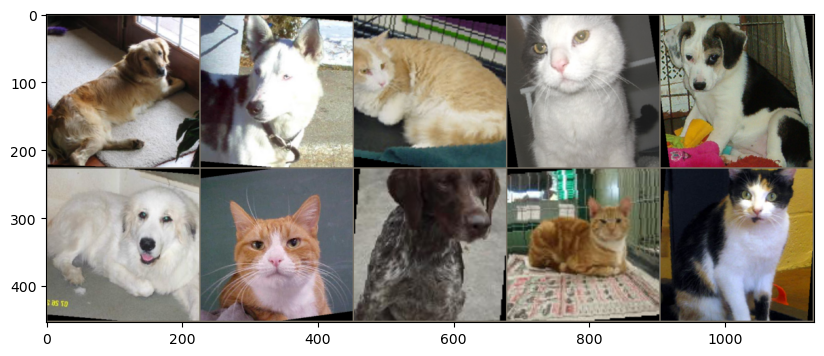

In [25]:
im = make_grid(images, nrow=5)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [28]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [29]:
(((224-2)/2)-2)/2

54.5

In [30]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [32]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
840
10


In [33]:
import time
start_time = time.time()

epochs = 3

# limits on num of batches, this step is optional
max_train_batch = 800  # batch_size = 10 images --> 8000 images
max_test_batch = 300  # batch_size = 10 images --> 3000 images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):

    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):

        # optional limit number of batches
        if b == max_train_batch:
            break

        b += 1

        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Total number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'Epoch {i} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(train_corr)


    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # optional limit number of batches
            if b == max_test_batch:
                break

            y_val = CNNmodel(X_test)

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            test_corr += batch_corr

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

total_time = time.time() - start_time

print(f'Total Time: {total_time/60} minutes')

Epoch 0 Loss: 0.6989785432815552
Epoch 0 Loss: 0.557498574256897
Epoch 0 Loss: 0.6110697984695435
Epoch 0 Loss: 0.5992476344108582
Epoch 1 Loss: 0.5096286535263062
Epoch 1 Loss: 0.5542506575584412
Epoch 1 Loss: 0.28209689259529114
Epoch 1 Loss: 0.5352689027786255
Epoch 2 Loss: 0.38851818442344666
Epoch 2 Loss: 0.33978715538978577
Epoch 2 Loss: 0.27854984998703003
Epoch 2 Loss: 0.36682116985321045
Total Time: 28.154951802889506 minutes


In [35]:
torch.save(CNNmodel.state_dict(), 'my3epochmodel_sm.pt')

In [36]:
train_losses = [loss.item() for loss in train_losses]
test_losses = [loss.item() for loss in test_losses]

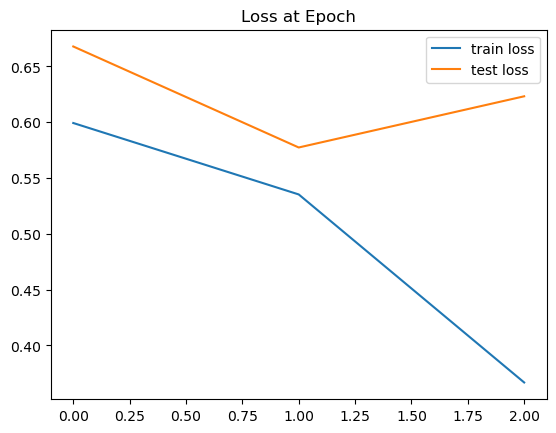

In [37]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at Epoch')
plt.legend()

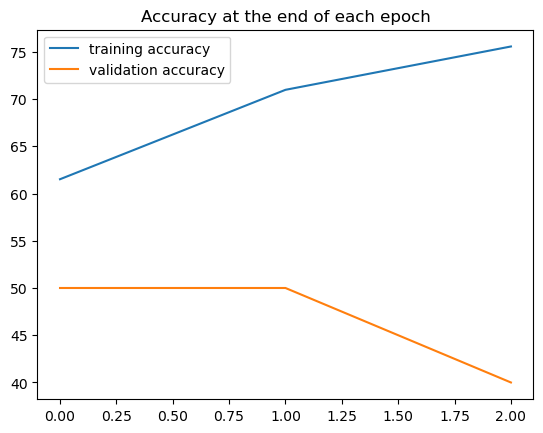

In [38]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [39]:
test_correct[-1].item()/3000

0.4